# Visualize descriptor space with PCA
This notebook demonstrates how to visualize the descriptor space for a collection of structures using Principal Component Analysis (PCA) as implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

## Setup example system and calculate descriptors.
We start by generating a few rattled structures and energy-volume (EV) curves for `PbTe`. Note that the unit cell for the EV-structures is repeated. This is to demonstrate that all structures in a dataset does not necessarily have the same number of atoms. 

The descriptors for each strucutre are calculated using `calorine.nep.get_descriptors`, and stored in `descriptors`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bulk
from sklearn.decomposition import PCA

from calorine.nep import get_descriptors

In [2]:
descriptors = []

# Generate a few different rattled structures
for i in range(50):
    structure = bulk('PbTe', crystalstructure='rocksalt', a=6.7)
    structure.rattle(stdev=0.2, seed=i)
    descriptors.append(get_descriptors(structure))
    
# Generate a few larger structures with (rattled) energy-volume curves as well
for i in range(3):
    for volscale in np.arange(0.7, 0.85, 0.01):
        structure = bulk('PbTe', crystalstructure='rocksalt', a=6.7).repeat(2)
        latscale = volscale ** (1 / 3)
        structure.set_cell(structure.cell * latscale, scale_atoms=True)
        structure.rattle(stdev=0.2, seed=i)
        descriptors.append(get_descriptors(structure))

## Performing a PCA on the descriptors
We can now perform the PCA. Note that the descriptors must be concatenated into a matrix with shape `(total number of atoms in dataset, descriptors components)`. 

Don't forget to check the `pca.explained_variance_ratio_` property after the fit, to check if the PCA components represent the original high-dimensional descriptor space well. 

(total number of atoms in dataset, descriptor components): (868, 52)
The explained variance is 0.72 for component 0 and 0.14 for component 1


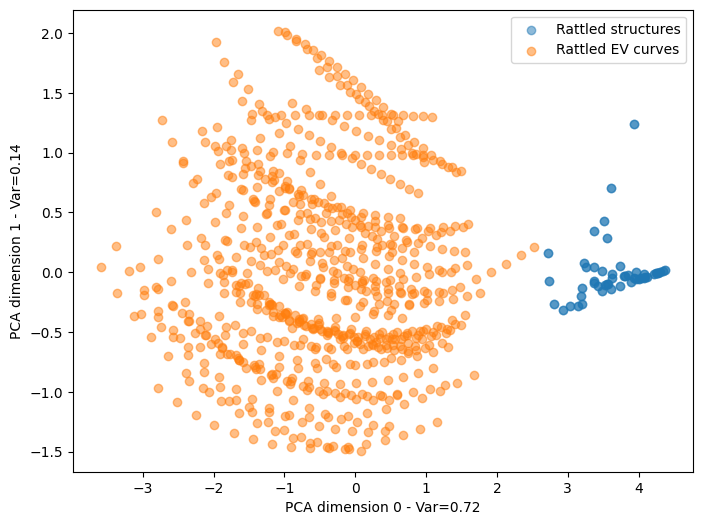

In [3]:
# Concatenate all descriptors
all_descriptors = np.concatenate(descriptors, axis=0)
print('(total number of atoms in dataset, descriptor components): {shape}'.format(shape=all_descriptors.shape))

# Perform PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(all_descriptors)

print('The explained variance is {p0:.2f} for component 0 and {p1:.2f} for component 1'.format(
    p0=pca.explained_variance_ratio_[0], 
    p1=pca.explained_variance_ratio_[1])
)

# Plot resulting PCA
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pc[:100,0], pc[:100,1], alpha=0.5, label='Rattled structures')
ax.scatter(pc[100:,0], pc[100:,1], alpha=0.5, label='Rattled EV curves')
ax.set_xlabel(f'PCA dimension 0 - Var={pca.explained_variance_ratio_[0]:.2f}')
ax.set_ylabel(f'PCA dimension 1 - Var={pca.explained_variance_ratio_[1]:.2f}')
ax.legend(loc='best')

## Normalized vs. non-normalized descriptors
Clusters in descriptor space are often more clearly separable if the descriptors are normalized beforehand. Note that the normalization is taken over each atom, rather than over structures. This is due to the structures (possibly) being of different size. 

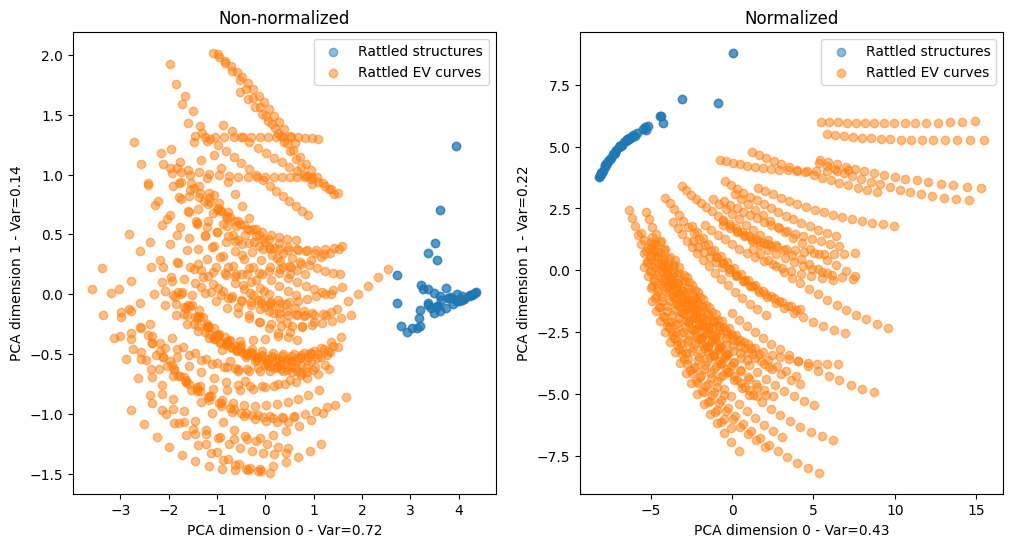

In [4]:
descriptor_mean, descriptor_std = all_descriptors.mean(axis=0), all_descriptors.std(axis=0)
normalized_descriptors = [(descriptor - descriptor_mean) / descriptor_std for descriptor in descriptors]

pca = PCA(n_components=2)

fig, axs = plt.subplots(1,2,figsize=(12,6))
pc = pca.fit_transform(all_descriptors)
axs[0].scatter(pc[:100,0], pc[:100,1], alpha=0.5, label='Rattled structures')
axs[0].scatter(pc[100:,0], pc[100:,1], alpha=0.5, label='Rattled EV curves')
axs[0].set_xlabel(f'PCA dimension 0 - Var={pca.explained_variance_ratio_[0]:.2f}')
axs[0].set_ylabel(f'PCA dimension 1 - Var={pca.explained_variance_ratio_[1]:.2f}')
axs[0].set_title("Non-normalized")
axs[0].legend(loc='best')

norm_pc = pca.fit_transform(np.concatenate(normalized_descriptors, axis=0))
axs[1].scatter(norm_pc[:100,0], norm_pc[:100,1], alpha=0.5, label='Rattled structures')
axs[1].scatter(norm_pc[100:,0], norm_pc[100:,1], alpha=0.5, label='Rattled EV curves')
axs[1].set_xlabel(f'PCA dimension 0 - Var={pca.explained_variance_ratio_[0]:.2f}')
axs[1].set_ylabel(f'PCA dimension 1 - Var={pca.explained_variance_ratio_[1]:.2f}')
axs[1].set_title("Normalized")
axs[1].legend(loc='best')